# Multi-View-Majority-Vote-Learning-Algorithms-Direct-Minimization-of-PAC-Bayesian-Bounds

This Notebook contains everything necessary to reproduce the experiments in our paper:  

*Multi-View Majority Vote Learning Algorithms: Direct Minimization of PAC-Bayesian Bounds*

## Imports

In [1]:
# %pip install -r requirements.txt

In [1]:
import os
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from collections import OrderedDict
from termcolor import colored

# Scikit-learn
from sklearn import preprocessing
from sklearn.utils import check_random_state

# torch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter
from torch.autograd import Variable
from torch.utils.data import DataLoader,Dataset
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


from mvpb import MultiViewBoundsDeepNeuralDecisionForests, MajorityVoteBoundsDeepNeuralDecisionForests


# Import data
from mvlearn.datasets import load_UCImultifeature
from data import (SampleData,
                           Nhanes,
                           MultipleFeatures,
                           MNIST_MV_Datasets,
                           Fash_MNIST_MV_Datasets,
                           EMNIST_Letters_MV_Datasets,
                           Mushrooms,
                           PTB_XL_plus,
                           Nutrimouse,
                           ReutersEN,
                           IS,
                           CorelImageFeatures,
                           NUS_WIDE_OBJECT,
                           ALOI,
                           train_test_split,
                           train_test_merge,
                           s1_s2_split,
                           multiclass_to_binary,
                           balance_dataset,
                           other_binary_options,
                           poison_dataset)
from mvpb.util import uniform_distribution

## Load and prepare the multiview datasets

In [2]:
dataset = MNIST_MV_Datasets(sample=1)
X_train, y_train, X_test, y_test = dataset.get_data()
if isinstance(dataset, PTB_XL_plus):
    real_classes = dataset.get_real_classes(np.unique(y_train))

Xs_train = []
Xs_test = []
for xtr, xts in zip(X_train, X_test):
    scaler = preprocessing.MinMaxScaler().fit(xtr)
    Xs_train.append(scaler.transform(xtr))
    Xs_test.append(scaler.transform(xts))

X_train_concat = [np.concatenate(Xs_train, axis=1)]
X_test_concat = [np.concatenate(Xs_test, axis=1)]

np.unique(y_train), np.unique(y_test)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]))

In [3]:
X_train[1].shape, y_train.shape, X_test[1].shape, y_test.shape

((56000, 196), (56000,), (14000, 196), (14000,))

In [4]:
RUNS = range(3)

OPTIMIZE_LAMBDA_GAMMA = True
# ALPHA = [1, 0.5, 1.1, 2]
ALPHA = [1.1]
MAX_ITER = 1000

stump_config = {
    "name": "stump",
    "n_estimators": 100,
    "max_depth": 1,
    "max_features": 0.5,
}
weak_learners_config = {
    "name": "weak_learner",
    "n_estimators": 100,
    "max_depth": 3,
    "max_features": 0.5,
}
strong_learners_config = {
    "name": "strong_learner",
    "n_estimators": 100,
    "max_depth": 6,
    "max_features": 0.8,
}

# CFG = [stump_config, weak_learners_config, strong_learners_config]
CFG = [weak_learners_config]

EPOCHS = 15

TO_BINARY  = "ovo" # One of ["ovr", "ovo", "other",  None]
label_1 = 4
# if isinstance(dataset, PTB_XL_plus):
#     label_1 = np.unique(y_test)[np.where(real_classes == "['NORM']")[0][0]]
label_2 = 9

POISON = False

USE_UNLABELED = False
s_labeled_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5] if USE_UNLABELED else [0.1]

# BOUNDS = ['Uniform', 'TND_DIS', 'TND', 'DIS', 'Lambda', 'KLinv']
BOUNDS = ['KLinv']

m = y_train.size #350
test_size = 1 - (m  / (y_test.size+y_train.size))
experiments = {}
for s_labeled_size in s_labeled_sizes:
    experiments[s_labeled_size] = {}
    for alpha in ALPHA:
        experiments[s_labeled_size][alpha] = {}
        for cfg in CFG:
            experiments[s_labeled_size][alpha][cfg["name"]] = []

In [5]:
experiments

{0.1: {1.1: {'weak_learner': []}}}

In [6]:
# if POISON:
#     Xs_train, y_train = poison_dataset(Xs_train, y_train, poison_label=label_1, target_label=label_2, target_view=3, num_samples=4000)

In [7]:
# Transform to binary OVR (One Vs Rest) or OVO (One Vs One) if needed
if TO_BINARY == "ovr":
    Xs_train, y_train, Xs_test, y_test = multiclass_to_binary(Xs_train, y_train, Xs_test, y_test, type=TO_BINARY, label_1=label_1)
elif TO_BINARY == "ovo":
    Xs_train, y_train, Xs_test, y_test = multiclass_to_binary(Xs_train, y_train, Xs_test, y_test, type=TO_BINARY, label_1=label_1, label_2=label_2)
elif TO_BINARY == "other":
    y_train, y_test = other_binary_options(dataset, y_train, y_test)
else:
    print(colored(f"WARNING: TO_BINARY={TO_BINARY}, continuing", 'yellow'))

In [8]:
before_merge = (Xs_train, y_train, Xs_test, y_test)
Xs, y = train_test_merge(Xs_train, y_train, Xs_test, y_test)
os.makedirs("results", exist_ok=True)
    

# iterate over the labeled data sizes #
for i, s1_size in enumerate(s_labeled_sizes):
    print(colored(f"############ Using {s1_size*100}% labeled data ############", 'black', on_color='on_blue'))
    s_labeled_dir = 'results'+f"/s_labeled-{int(s1_size*100)}"
    os.makedirs(s_labeled_dir, exist_ok=True)
### iterate over the alpha values ###
    
    for j, alpha in enumerate(ALPHA):
        print(colored(f"\t############ Using {alpha=} ############", 'black', on_color='on_blue'))
        alpha_dir = s_labeled_dir+ f"/alpha-{alpha}"
        os.makedirs(alpha_dir, exist_ok=True)
        
#### iterate over the configurations ####
        for k, config in enumerate(CFG):
            print(colored(f"\t\t############ Using {config['name']} ############", 'black', on_color='on_blue'))
            for run in RUNS:
                print(colored(f"\n----------------Run {run+1}---------------", 'blue'))

                # Shuffle and split the dataset into training and testing
                # if not dataset.split:
                #     Xs_train, y_train, Xs_test, y_test = train_test_split(Xs, y, test_size=test_size, random_state=run*(i+1)*(j+1)*(k+1))
                # else:
                Xs_train, y_train, Xs_test, y_test = before_merge

                # Split the dataset into labeled and unlabeled
                Xs_train, y_train, UlX, _ = s1_s2_split(Xs_train, y_train, s1_size=s1_size, random_state=run*(i+1)*(j+1)*(k+1))
                X_train_concat = np.concatenate(Xs_train, axis=1)
                X_test_concat = np.concatenate(Xs_test, axis=1)
                    
                # instantiate multiview dNDF classifier
                dNDF_mv = MultiViewBoundsDeepNeuralDecisionForests(nb_estimators=config["n_estimators"],
                                                        nb_views=len(Xs_train),
                                                        depth =config["max_depth"],
                                                        used_feature_rate=config["max_features"],
                                                        random_state=run,
                                                        epochs=EPOCHS,
                                                        use_dndf=False)
                
                # instantiate dNDF classifier for separate views and concatenated view
                dNDF_per_view = []
                for v in range(len(Xs_train)+1):
                    dNDF_per_view.append(MajorityVoteBoundsDeepNeuralDecisionForests(nb_estimators=config["n_estimators"],
                                                            depth =config["max_depth"],
                                                            used_feature_rate=config["max_features"],
                                                            random_state=run,
                                                            epochs=EPOCHS,
                                                            use_dndf=False))
                
                print("Training multiview classifier-------------------------------")
                dNDF_mv.fit(Xs_train, y_train)
                
                print("Training separate views classifiers-------------------------------")
                for v in range(len(Xs_train)):
                    dNDF_per_view[v].fit(Xs_train[v], y_train)

                print("Training concatenated view classifier-------------------------------")
                dNDF_per_view[-1].fit(X_train_concat, y_train)
                
                
                # Optimize the posterior distributions for the each bound
                for bound in BOUNDS:
                    # Clear the posteriors (reset to uniform distribution)
                    dNDF_mv.clear_posteriors()
                    for v in range(len(Xs_train)):
                        dNDF_per_view[v].clear_posteriors()
                    
                    # use the unlabeled data for DIS
                    unlabeled_data, c_unlabeled_data = None, None
                    if USE_UNLABELED and bound in ["DIS", "TND_DIS"]:
                        unlabeled_data = UlX
                        c_unlabeled_data = np.concatenate(UlX, axis=1)
                        
                    if bound != "Uniform":
                        _, gibbs_risk, _ = dNDF_mv.mv_risks((Xs_train, y_train), incl_oob=False)
                        print(f"### Multiview classifier gibbs risk before Optim: {gibbs_risk}")
                        print(colored(f"Optimizing {bound} for multiview classifier-------------------------------", 'green'))
                        posterior_Qv , posterior_rho = dNDF_mv.optimize_rho(bound,
                                                                            labeled_data=(Xs_train, y_train),
                                                                            unlabeled_data=unlabeled_data,
                                                                            incl_oob=False,
                                                                            max_iter=MAX_ITER,
                                                                            optimise_lambda_gamma=OPTIMIZE_LAMBDA_GAMMA,
                                                                            alpha=alpha)
                        
                        if bound != "KLinv":
                            print(colored(f"Optimizing {bound} for separate views classifiers-------------------------------", 'green'))
                            posterior_Qs = []
                            for v in range(len(Xs_train)):
                                posterior_Q = dNDF_per_view[v].optimize_Q(bound,
                                                                                labeled_data=(Xs_train[v], y_train),
                                                                                unlabeled_data=unlabeled_data[v] if unlabeled_data else None,
                                                                                incl_oob=False,
                                                                                max_iter=MAX_ITER,
                                                                                optimise_lambda_gamma=OPTIMIZE_LAMBDA_GAMMA,
                                                                                alpha=1)
                                posterior_Qs.append(posterior_Q)
                            print(colored(f"Optimizing {bound} for concatenated classifier-------------------------------", 'green'))
                            posterior_Q_concat = dNDF_per_view[-1].optimize_Q(bound,
                                                                                labeled_data=(X_train_concat, y_train),
                                                                                unlabeled_data=c_unlabeled_data,
                                                                                incl_oob=False,
                                                                                max_iter=MAX_ITER,
                                                                                optimise_lambda_gamma=OPTIMIZE_LAMBDA_GAMMA,
                                                                                alpha=1)
                            posterior_Qs.append(posterior_Q_concat)
                        
                        _, gibbs_riska, _ = dNDF_mv.mv_risks((Xs_train, y_train), incl_oob=False)
                        print(f"### Multiview classifier gibbs risk after Optim: {gibbs_riska}")
                        # Compute the bound for the multiview classifier
                        print(colored(f"Optimization is done! -------------------------------", 'green'))
                    
                    print(colored(f"Computing the bound values ans risks -------------------------------", 'green'))
                    mv_bound, r1, r2, klqp, klrpi,  n1, n2 = dNDF_mv.bound(
                                        bound=bound,
                                        labeled_data=(Xs_train, y_train),
                                        unlabeled_data=unlabeled_data,
                                        incl_oob=False,
                                        alpha=alpha)
                    if bound != "KLinv":
                        for v in range(len(Xs_test)):
                            v_bound, _, _, _, _, _ = dNDF_per_view[v].bound(
                                            bound=bound,
                                            labeled_data=(Xs_train[v], y_train),
                                            unlabeled_data=unlabeled_data[v] if unlabeled_data else None,
                                            incl_oob=False,
                                            alpha=1)
                            v_bounds.append(v_bound)
                        concat_bound, _, _, _, _, _ = dNDF_per_view[-1].bound(
                                            bound=bound,
                                            labeled_data=(X_train_concat, y_train),
                                            unlabeled_data=c_unlabeled_data,
                                            incl_oob=False,
                                            alpha=1)
                        v_bounds.append(concat_bound)
                    # print(f"{dNDF_mv.posterior_Qv=} {dNDF_mv.posterior_rho=}")
                    
                    # Compute the risk of the multiview classifier
                    P, mv_risk = dNDF_mv.predict_MV(Xs_test, y_test)
                    v_risks = [dNDF_per_view[v].predict(Xs_test[v], y_test)[1] for v in range(len(Xs_test))]
                    v_risks.append(dNDF_per_view[-1].predict(X_test_concat, y_test)[1])
                    
                    v_bounds = v_risks
                    # Save the results
                    print(colored(f"Entering save and stats zone-------------------------------", 'green'))
                    views_risks = {f"View{i+1}": v_risks[i] for i in range(len(v_risks)-1)}
                    views_risks.update({"Concatenated": v_risks[-1]})
                    views_risks.update({"Multiview": mv_risk})
                    views_bounds = {f"View{i+1}": v_bounds[i] for i in range(len(v_bounds)-1)}
                    views_bounds.update({"Concatenated": v_bounds[-1]})
                    views_bounds.update({"Multiview": mv_bound})
                    for (kr, r), (kb, b) in zip(views_risks.items(), views_bounds.items()):
                        assert kr == kb # check if the keys are the same
                        exp = {"Run": run+1, 
                            "Bound_name": bound, 
                            "View": kr, 
                            "Risk": "{:.3f}".format(r),
                            "Bound": "{:.3f}".format(b),
                            "R1": "{:.3f}".format(r1),
                            "R2": "{:.3f}".format(r2),
                            "KLqp": "{:.3f}".format(klqp),
                            "KLRpi": "{:.3f}".format(klrpi),
                            "N1": "{:.3f}".format(n1),
                            "N2": "{:.3f}".format(n2),}
                        experiments[s1_size][alpha][config["name"]].append(exp)
                    # TODO: add the posterior_Qv and posterior_rho to the experiment
                del dNDF_mv, dNDF_per_view
                
            cfg_dir = alpha_dir + "/" + config["name"]
            os.makedirs(cfg_dir, exist_ok=True)
            experiment_df = pd.DataFrame(experiments[s1_size][alpha][config["name"]])
            # example: results/s_labeled-5/alpha-1/stump/MNIST_4vs9_20runs.csv
            file_name = f"{cfg_dir}/{dataset._name}_{label_1}vs{label_2}_{len(RUNS)}runs.csv"
            experiment_df.to_csv(file_name, sep=" ", index=False)

############ Using 10.0% labeled data ############
	############ Using alpha=1.1 ############
		############ Using weak_learner ############

----------------Run 1---------------
Training multiview classifier-------------------------------
Training separate views classifiers-------------------------------
Training concatenated view classifier-------------------------------
### Multiview classifier gibbs risk before Optim: 0.2737184684684685
Optimizing KLinv for multiview classifier-------------------------------
emp_mv_risk.item()=0.27371846235038394
emp_mv_risk.item()=0.27268689100125026
emp_mv_risk.item()=0.2716403339707617
emp_mv_risk.item()=0.2705479154193346
emp_mv_risk.item()=0.26937807175187994
emp_mv_risk.item()=0.26809694835933295
emp_mv_risk.item()=0.26666696628766917
emp_mv_risk.item()=0.2650454172657336
emp_mv_risk.item()=0.26318250795531356
emp_mv_risk.item()=0.26101981083816705
emp_mv_risk.item()=0.2584886525545848
emp_mv_risk.item()=0.255506241177311
emp_mv_risk.item()=0

In [9]:
Xs_test[0].shape, Xs_train[0].shape

((2676, 196), (1110, 196))

In [10]:
os.makedirs("results-dup", exist_ok=True)

for s_labeled_size, size_exp in experiments.items():
    s_labeled_dir = 'results-dup'+f"/s_labeled-{int(s_labeled_size*100)}"
    os.makedirs(s_labeled_dir, exist_ok=True)
    for alpha, alpha_exp in size_exp.items():
        alpha_dir = s_labeled_dir+ f"/alpha-{alpha}"
        os.makedirs(alpha_dir, exist_ok=True)
        for cfg, cfg_exp in alpha_exp.items():
            if cfg_exp == []:
                continue
            cfg_dir = alpha_dir + "/" + cfg
            os.makedirs(cfg_dir, exist_ok=True)
            experiment_df = pd.DataFrame(cfg_exp)
            # example: results-dup/s_labeled-5/alpha-1/stump/MNIST_4vs9_20runs.csv
            file_name = f"{cfg_dir}/{dataset._name}_{label_1}vs{label_2}_{len(RUNS)}runs.csv"
            experiment_df.to_csv(file_name, sep=" ", index=False)


In [11]:
df = pd.DataFrame(experiments[0.1][1.1]["weak_learner"])
df["Risk"] = df["Risk"].astype(float)
df["Bound"] = df["Bound"].astype(float)
# df['Bound'] = df['Bound'].apply(lambda x: x[0] if isinstance(x, (list, np.ndarray)) else x)
# df['Risk'] = df['Risk'].apply(lambda x: x[0] if isinstance(x, (list, np.ndarray)) else x)
df.head(50)

,Run,Bound_name,View,Risk,Bound,R1,R2,KLqp,KLRpi,N1,N2
0,1,KLinv,View1,0.188,0.188,0.080,-1.000,0.568,0.525,1110.000,-1.000
1,1,KLinv,View2,0.091,0.091,0.080,-1.000,0.568,0.525,1110.000,-1.000
2,1,KLinv,View3,0.284,0.284,0.080,-1.000,0.568,0.525,1110.000,-1.000
3,1,KLinv,View4,0.256,0.256,0.080,-1.000,0.568,0.525,1110.000,-1.000
4,1,KLinv,Concatenated,0.083,0.083,0.080,-1.000,0.568,0.525,1110.000,-1.000
5,1,KLinv,Multiview,0.105,0.237,0.080,-1.000,0.568,0.525,1110.000,-1.000
6,2,KLinv,View1,0.181,0.181,0.089,-1.000,0.557,0.509,1110.000,-1.000
7,2,KLinv,View2,0.094,0.094,0.089,-1.000,0.557,0.509,1110.000,-1.000
8,2,KLinv,View3,0.307,0.307,0.089,-1.000,0.557,0.509,1110.000,-1.000
9,2,KLinv,View4,0.268,0.268,0.089,-1.000,0.557,0.509,1110.000,-1.000


In [12]:
df[df["Risk"] > df["Bound"]]

,Run,Bound_name,View,Risk,Bound,R1,R2,KLqp,KLRpi,N1,N2


In [13]:
# agg_df = df.groupby(["Bound_name", "View"]).mean()
# agg_df

In [12]:
def plot_results_grid(exps, m, runs=len(RUNS), bounds=BOUNDS):

    sns.set_style(style="ticks")
    bounds_palette = sns.color_palette("viridis", n_colors=len(bounds))
    risk_palette = sns.color_palette("flare", n_colors=len(bounds))
    risk_palette.reverse()

    num_views = len(exps['View'].unique())
    num_cols = num_views // 2 + num_views % 2  # Calculate number of columns for subplots

    fig, ax = plt.subplots(2, num_cols, figsize=(14, 10), sharey=True)

    for i, view in enumerate(exps['View'].unique()):
        view_data = exps[exps['View'] == view]
        row = i // num_cols
        col = i % num_cols
        
        risk = view_data.groupby(["Bound_name", "View"])['Risk'].mean()
        mean_risk = risk.median()
        # up_risk = mean_risk+risk.std()
        # lw_risk = mean_risk-risk.std()
        # print(mean_risk, up_risk, lw_risk)
        # Plot Bound
        sns.barplot(x='Bound_name', y='Bound', data=view_data, ax=ax[row, col], hue='Bound_name', hatch='.', palette=bounds_palette)        # Create a horizontal line at the median risk
        sns.barplot(x='Bound_name', y='Risk', data=view_data, ax=ax[row, col], hue='Bound_name', hatch='\\', palette=risk_palette)

        # ax[row, col].axhline(y=up_risk, color='b', linestyle='-', label='Q3 Risk')
        # ax[row, col].axhline(y=lw_risk, color='r', linestyle='--', label='Median Risk')
        # ax[row, col].axhline(y=mean_risk, color='g', linestyle='-', label='Q1 Risk')
        ax[row, col].set_title(f'{view}')
        ax[row, col].set_xlabel('Bounds')
        ax[row, col].set_ylabel('Means')

        

    # handles, labels = ax[0,0].get_legend_handles_labels()
    # labels = [labels[i]+" bound" if i < len(labels)/2 else labels[i]+" Gibbs risk" for i in range(len(labels))]
    # ax[0, 0].legend(handles, labels, title='Bounds', loc='upper right', fontsize='medium')
    fig.suptitle(f'Test error rates and multiview PAC-Bayesian bound values, {m=},\naveraged over {runs} runs')
    fig.tight_layout()
    plt.show()

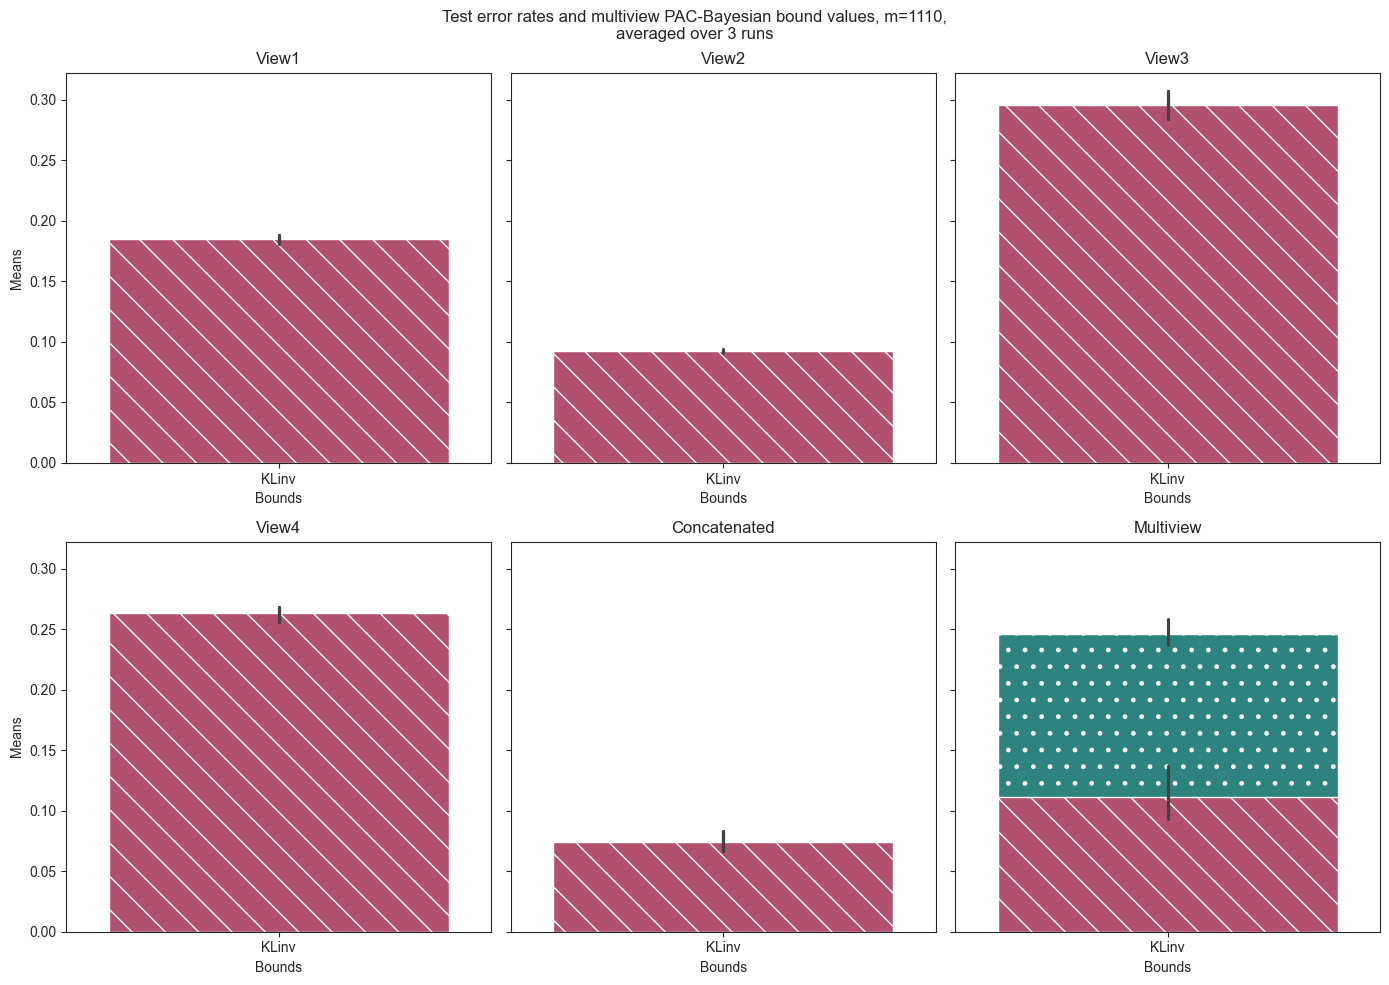

In [13]:
plot_results_grid(df, len(Xs_train[0]))

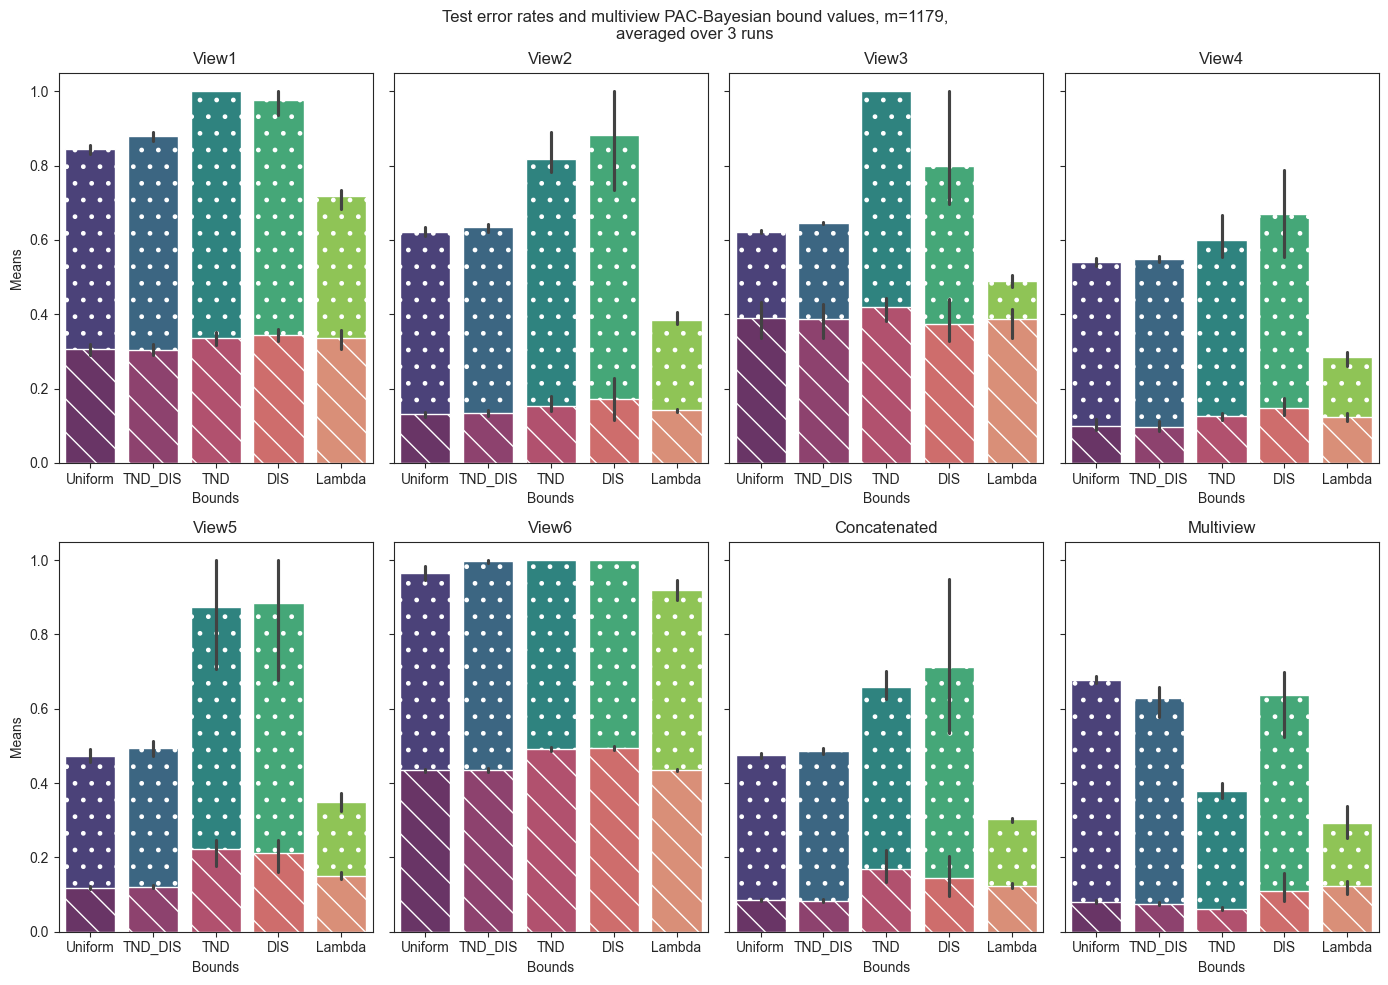

In [15]:
plot_results_grid(df, len(Xs_train[0]))

In [ ]:
posterior_rho

tensor([2.7044e-04, 3.1508e-03, 7.8344e-04, 6.9237e-03, 9.8858e-01, 2.8665e-04])

In [14]:
def plot_results(experiments, m, runs=len(RUNS), bounds=BOUNDS):
    sns.set_style(style="ticks")
    bounds_palette = sns.mpl_palette("viridis", n_colors=len(bounds))
    risk_palette = sns.color_palette("flare", n_colors=len(bounds))
    risk_palette.reverse()
    
    ax = sns.barplot(experiments, x='View', hue='Bound_name', y='Bound', errorbar="sd", width=0.8, hatch='.', palette=bounds_palette)
    ax = sns.barplot(experiments, x='View', hue='Bound_name', y='Risk', errorbar="sd", width=0.8, hatch='\\', palette=risk_palette)

    plt.title(f'Test error rates and multiview PAC-Bayesian bound values, {m=},\naveraged over {runs} runs')
    plt.xlabel('Views')
    plt.ylabel('Means')
    
    handles, labels = ax.get_legend_handles_labels()
    labels = [labels[i]+" bound" if i < len(labels)/2 else labels[i]+" Gibbs risk" for i in range(len(labels))]

    # Creating a unified legend for both plots
    plt.legend(handles, labels, title="Bounds and risks", loc='upper right', fontsize='medium')
    plt.tight_layout() 
    plt.gcf().set_size_inches(16, 10)
    plt.show()

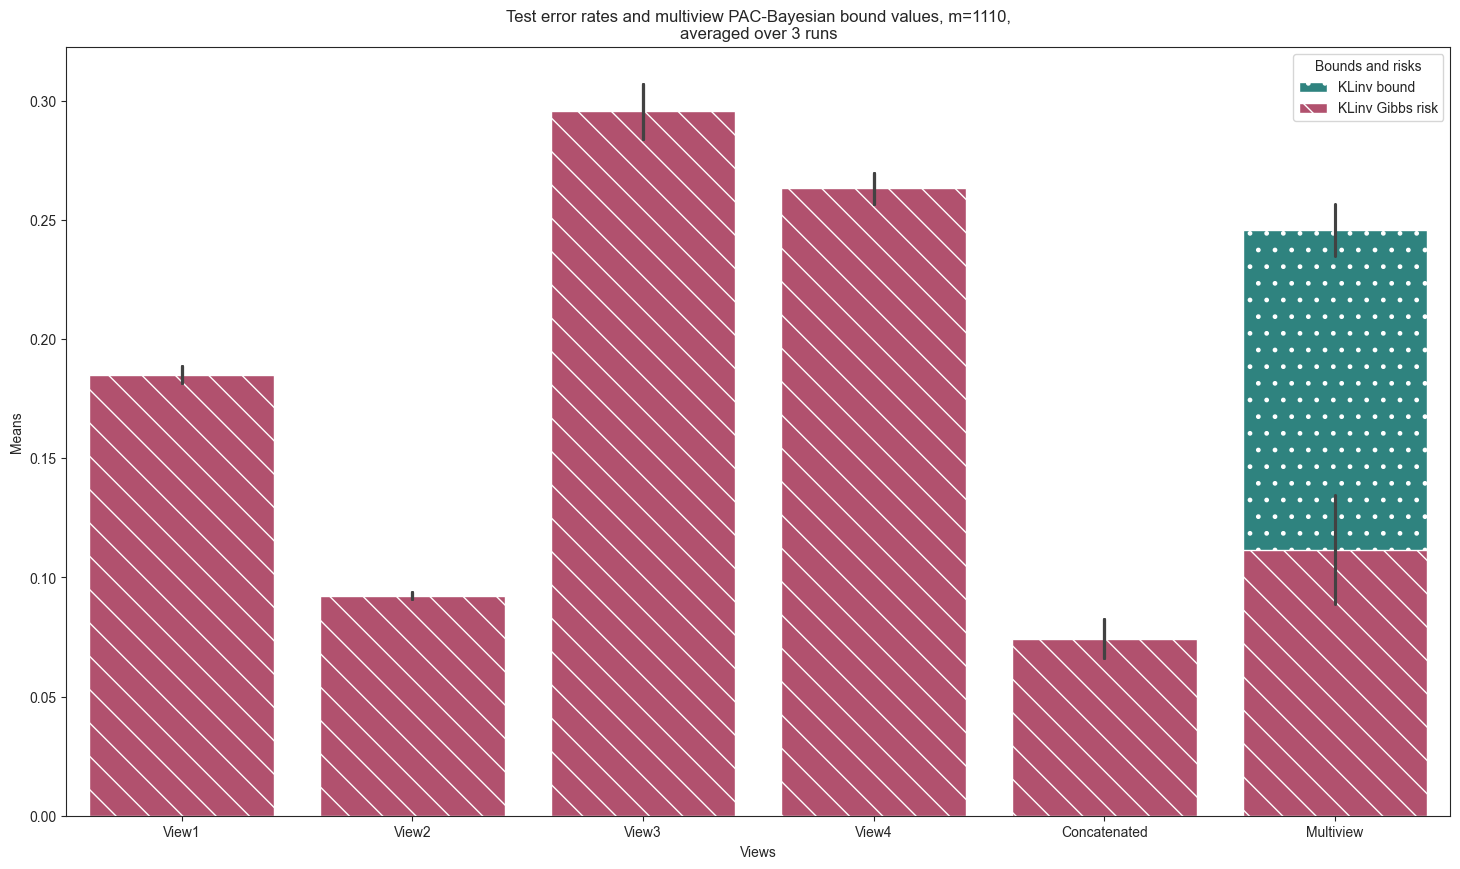

In [15]:
plot_results(df, len(Xs_train[0]))